# Fine Tuning Resnet 34 Focal Loss Clinic

Creamos una FocalLoss porque funciona bien con un dataset desbalanceado

In [134]:
class FocalLoss(nn.Module): # Se hereda la superclase nn.Module
    def __init__(self, gamma=2): # introducimos el parámetro gamma (valor por defecto = 2)
        super().__init__()
        self.gamma = gamma

    def forward(self, logit, target):
        target = target.float() 
        max_val = (-logit).clamp(min=0) # se introducen los logits por una función ReLU
        loss = logit - logit * target + max_val + \
               ((-max_val).exp() + (-logit - max_val).exp()).log() #se crea la función de pérdida

        invprobs = F.logsigmoid(-logit * (target * 2.0 - 1.0)) 
        loss = (invprobs * self.gamma).exp() * loss
        if len(loss.size())==2:
            loss = loss.sum(dim=1)
        return loss.mean()

learner_focal = None
learner_focal = cnn_learner(data, models.resnet34, metrics=[error_rate,accuracy], pretrained='imagenet')
# Se carga el modelo, se incluyen las métricas
learner_focal.loss_fn = FocalLoss() # Se añade la Focal Loss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


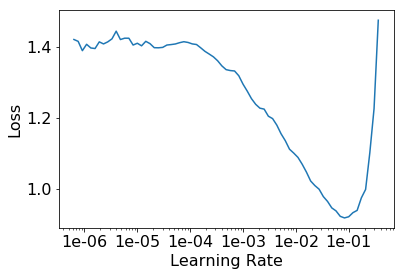

In [136]:
learner_focal.lr_find()
learner_focal.recorder.plot()

In [141]:
learner_focal.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.563606,0.247852,0.096220,0.903780,00:09
1,0.333267,0.226770,0.099656,0.900344,00:09
2,0.266932,0.166015,0.063574,0.936426,00:11
3,0.236482,0.134159,0.051546,0.948454,00:11
4,0.208044,0.105894,0.036082,0.963918,00:12
5,0.182604,0.081206,0.024055,0.975945,00:09
6,0.155129,0.081636,0.020619,0.979381,00:09
7,0.127574,0.087221,0.022337,0.977663,00:09


In [142]:
learner_focal.export('export_stage-1-34-Clinic_Focal_3_Classes')

learner_focal.unfreeze()
learner_focal.fit_one_cycle(4, max_lr=slice(1e-3,1e-2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.437696,6.198345,0.609966,0.390034,00:09
1,0.365929,1.068959,0.286942,0.713058,00:09
2,0.245240,0.247155,0.103093,0.896907,00:09
3,0.126401,0.082897,0.027491,0.972509,00:10


In [143]:
learner_focal.fit_one_cycle(2, max_lr=slice(3e-4,3e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.128458,0.313293,0.106529,0.893471,00:09
1,0.132957,0.082500,0.025773,0.974227,00:09


In [144]:
learner_focal.fit_one_cycle(2, max_lr=slice(3e-4,3e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.182259,0.608182,0.175258,0.824742,00:09
1,0.128420,0.086536,0.027491,0.972509,00:09


In [145]:
learner_focal.fit_one_cycle(2, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.117339,0.085601,0.025773,0.974227,00:09
1,0.125484,0.081868,0.024055,0.975945,00:09


In [146]:
learner_focal.fit_one_cycle(5, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.122701,0.080436,0.022337,0.977663,00:09
1,0.113523,0.081441,0.027491,0.972509,00:09
2,0.110348,0.086753,0.025773,0.974227,00:10
3,0.125839,0.085232,0.029210,0.970790,00:09
4,0.122625,0.081581,0.029210,0.970790,00:09


In [147]:
learner_focal.export('export_stage-2-34-Clinic_Focal_3_Classes')

interp = ClassificationInterpretation.from_learner(learner_focal)

interp.most_confused(min_val=2)

[('VARIANT_LYMPHOCYTE', 'BLAST', 6),
 ('VARIANT_LYMPHOCYTE', 'ATYPICAL_LYMPHOCYTE', 3),
 ('ATYPICAL_LYMPHOCYTE', 'BLAST', 2),
 ('ATYPICAL_LYMPHOCYTE', 'VARIANT_LYMPHOCYTE', 2),
 ('BLAST', 'ATYPICAL_LYMPHOCYTE', 2),
 ('BLAST', 'VARIANT_LYMPHOCYTE', 2)]

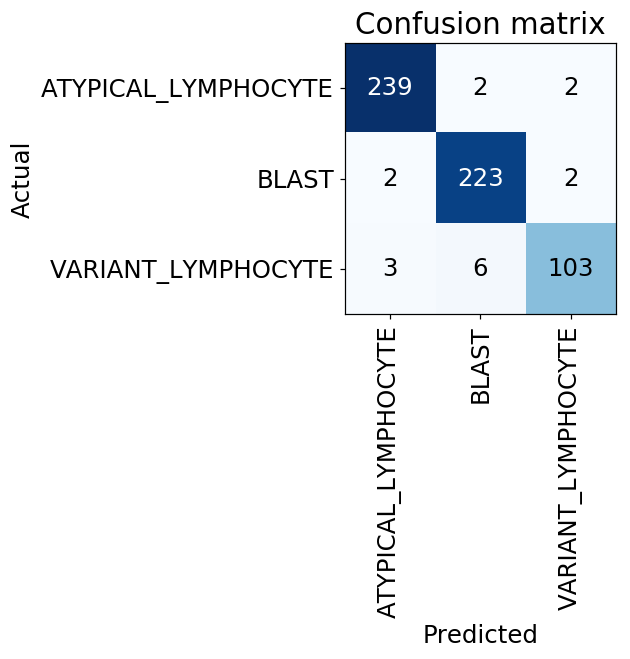

In [148]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=110)

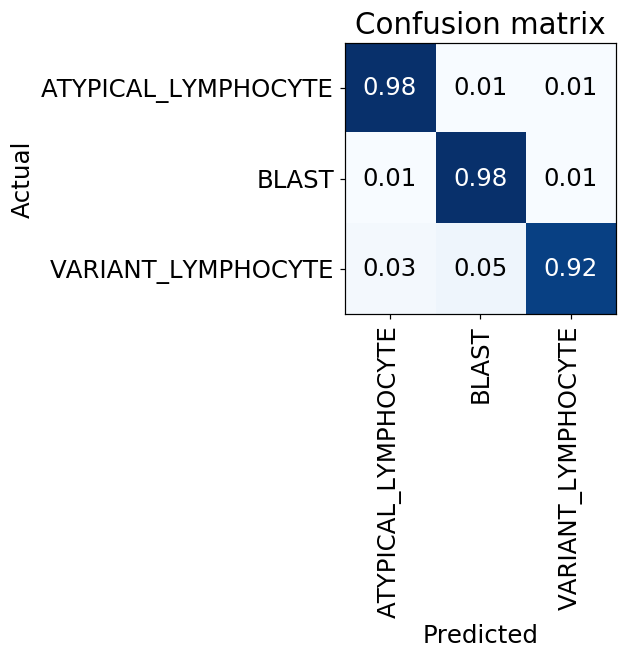

In [149]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=110, normalize=True)

In [170]:
learn_test_focal = load_learner('/shared/Classification_Clinic_Balanced', 'export_stage-2-34-Clinic_Focal_3_Classes')
learn_test_focal.data = data_test

In [171]:
metrics_valid_focal = learn_test_focal.validate(data_test.valid_dl)

In [172]:
valid_results_focal = dict(zip(['valid_loss', 'error_rate', 'accuracy'],
                         [metrics_valid_focal[0], metrics_valid_focal[1].item(),metrics_valid_focal[2].item()]))
pd.DataFrame(valid_results_focal, index = ['metrics'])

,valid_loss,error_rate,accuracy
metrics,0.080797,0.034091,0.965909


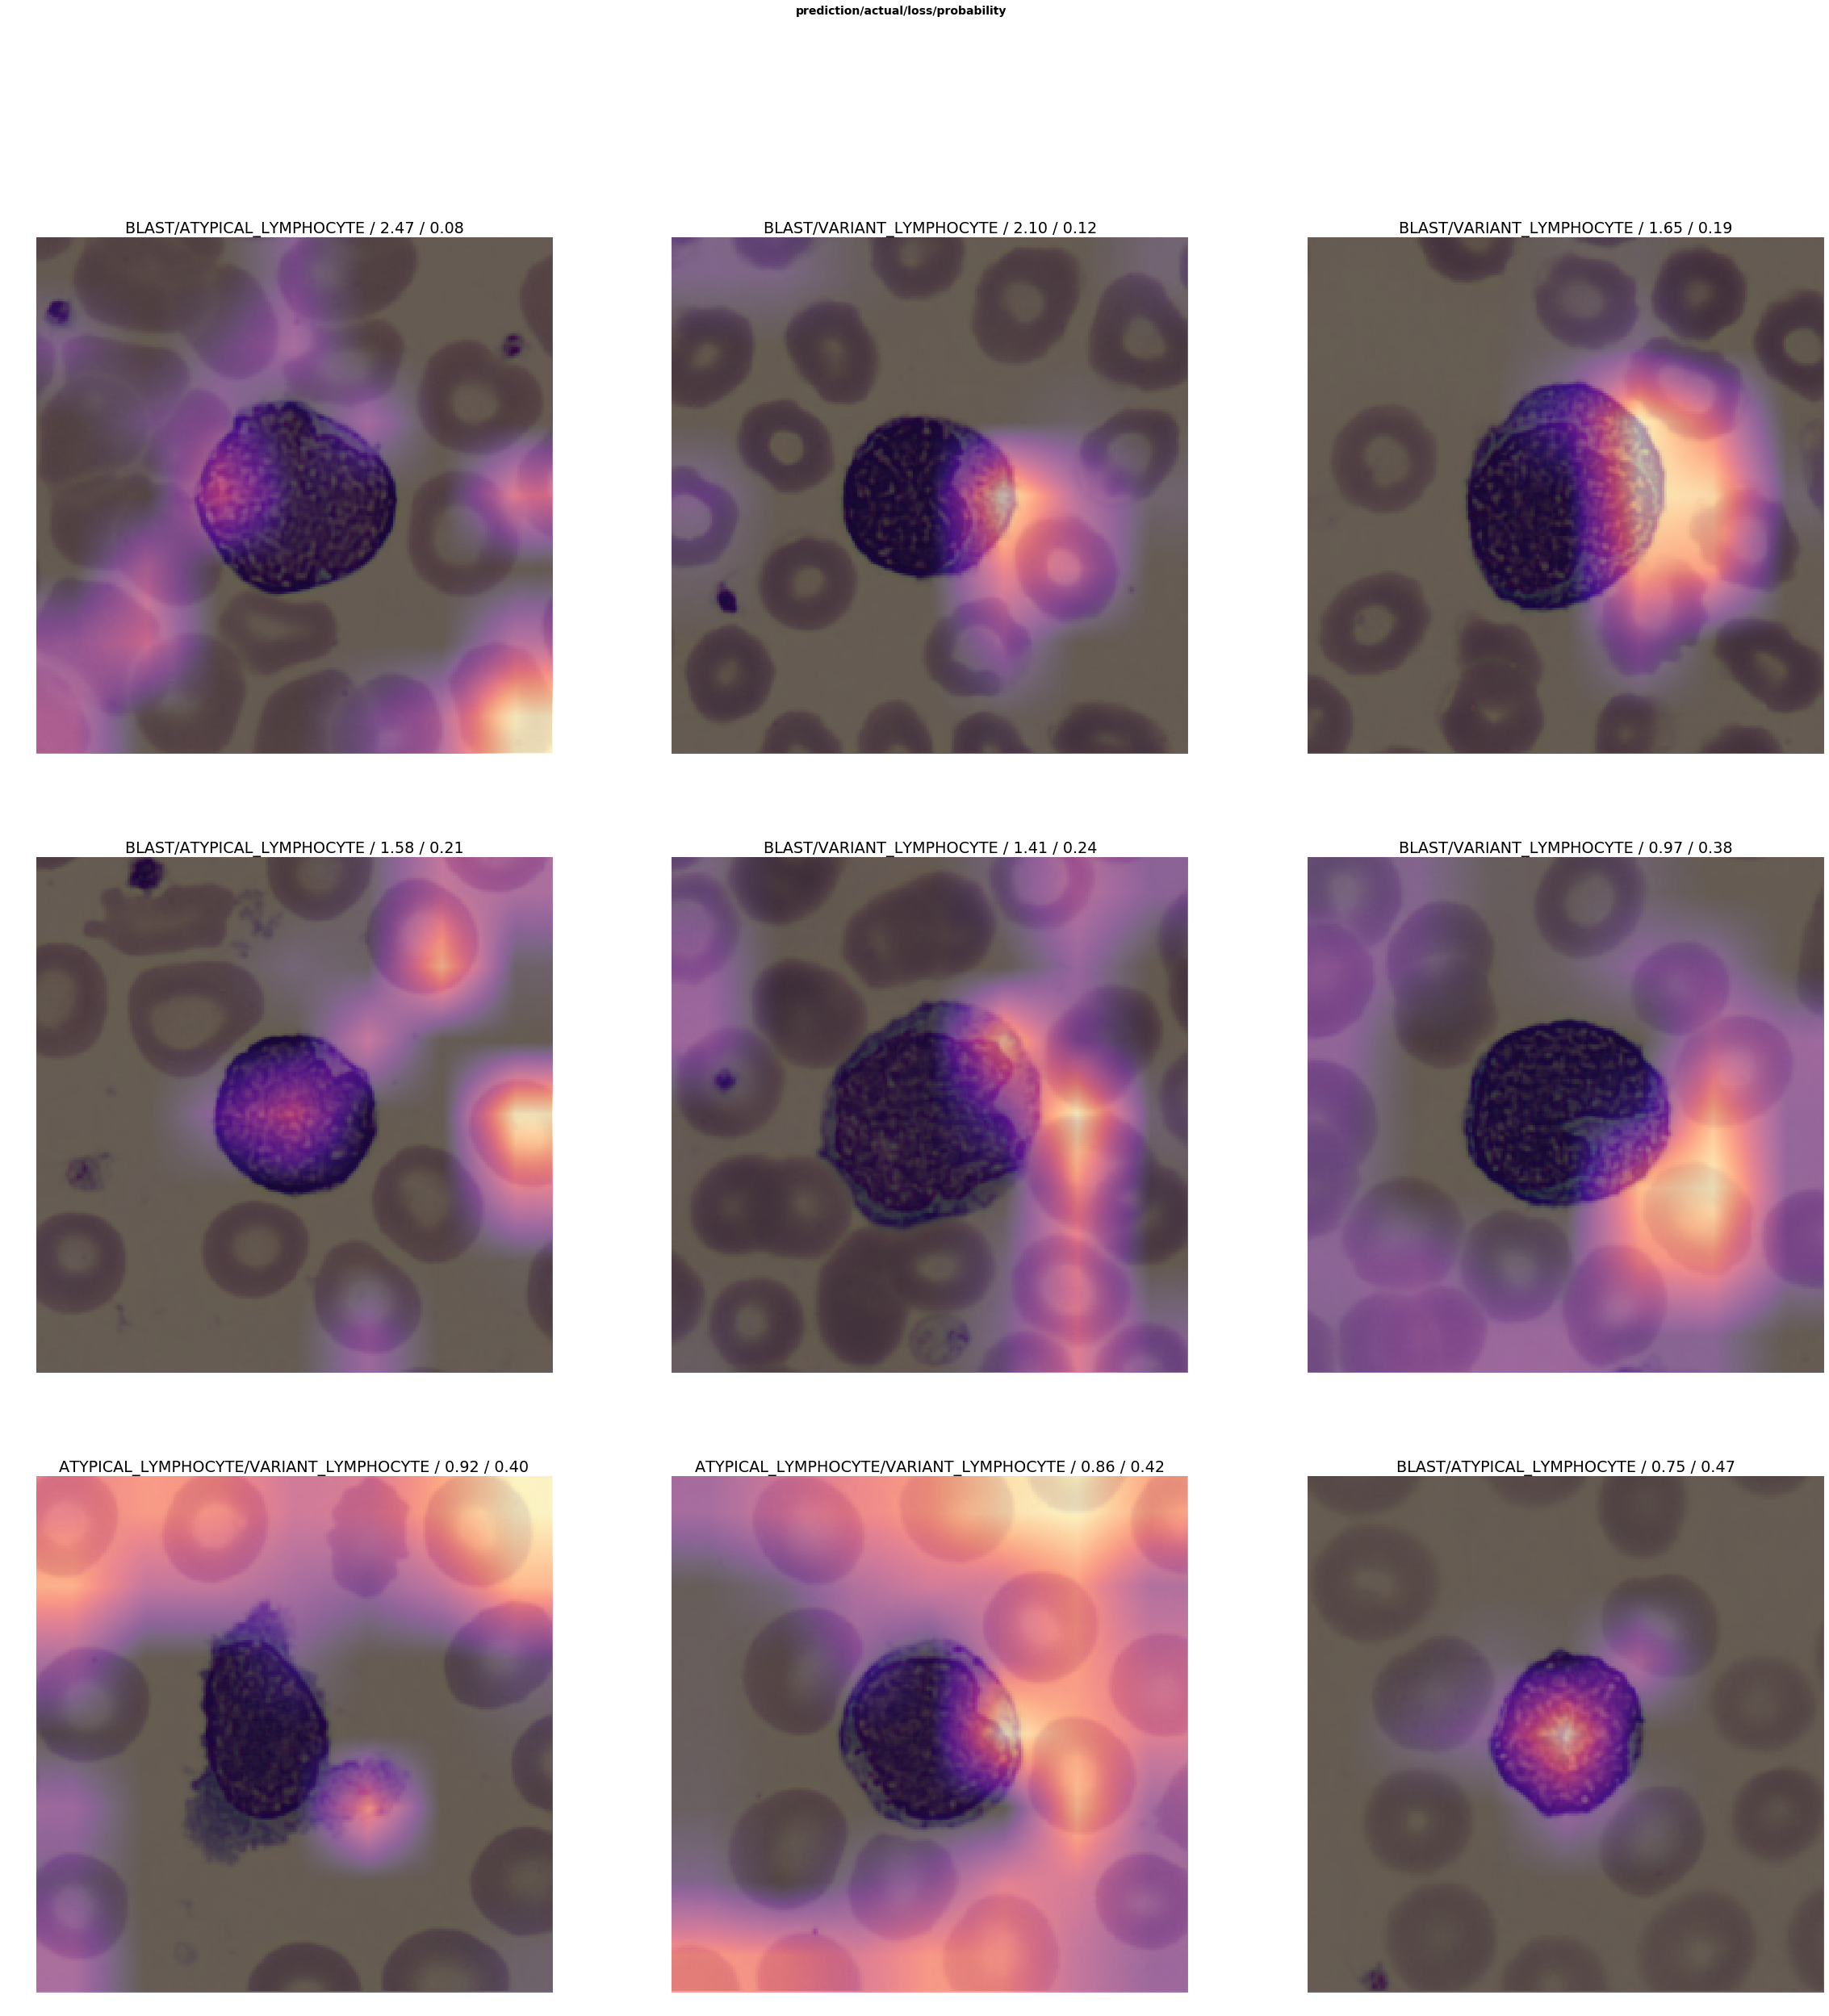

In [182]:
interp = ClassificationInterpretation.from_learner(learn_test_focal)
losses,idxs = interp.top_losses()
interp.plot_top_losses(9, largest=True, figsize=(40,40), heatmap=True)



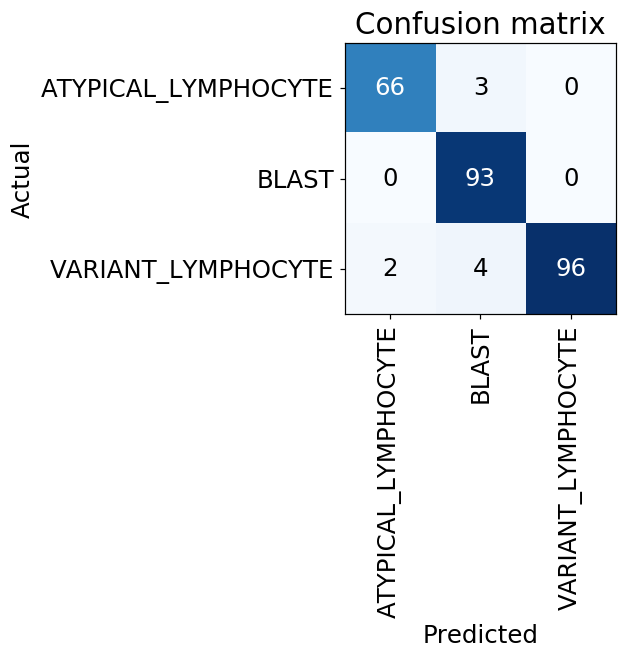

In [178]:
interp.plot_confusion_matrix(figsize=( 6,6), dpi=110)



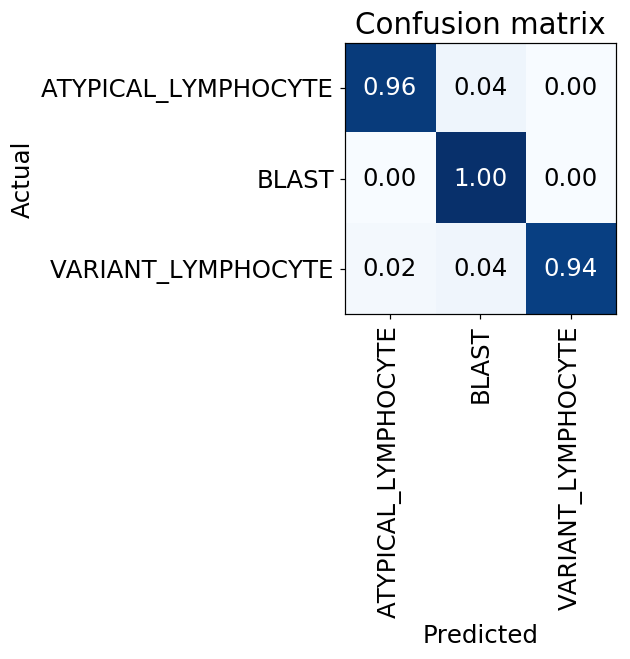

In [179]:
interp.plot_confusion_matrix(figsize=( 6,6), dpi=110, normalize=True)

In [180]:
len(data_test.valid_ds)==len(losses)==len(idxs)

True